# SOAM Quickstart
How to make an end to end project using SOAM modules and tools.

![soam_pipeline](documentation/images/SoaM_diagram.png)


This library pipeline supports any data source.
The process is structured in different stages:
* Extraction: manages the connection with the database, the time granularity and the aggregation level of the input data.
* Preprocessing: lets select among out of the box tools to perform standard tasks as normalization or fill nan values.
* Forecasting: fits a model and predict results.
* Postprocessing: modifies the results based on business/real information or create analysis with the predicted values,
 such as an anomaly detection.


## Extraction

This stage extracts data from the needed sources to build the condensed dataset for the next steps. This tends to be project dependent.

### Establish the connection with the database

In [1]:
from soam.workflow.time_series_extractor import TimeSeriesExtractor
from muttlib.dbconn import get_client

Postgres config set up

In [2]:
pg_cfg = {
    "host": "localhost",
    "port": 5432,
    "db_type": "postgres",
    "username": "mutt",
    "password": "mutt",
    "database": "sqlalchemy"
}

In [3]:
pg_client = get_client(pg_cfg)[1]

In [4]:
pg_client

In [5]:
extractor = TimeSeriesExtractor(db=pg_client, table_name='stocks_valuation')

#### Then it converts the full dataset to the desired time granularity and aggregation level by some categorical attribute/s and return it as a pandas data frame.
In this case we define the following: <br>
- Time granularity: <br>
     - Start date: 2021-03-01 <br>
     - End date: 2021-03-20
- Aggregation Level:
    - Order the date ascendantly.
    - Just stay with Apple's (AAPL) stock information.

In [132]:
build_query_kwargs={
    'columns': '*',
    'timestamp_col': 'date',
    'start_date': "2021-03-01",
    'end_date': "2021-03-20",
    'extra_where_conditions': ["symbol = 'AAPL'"],
    'order_by': ["date ASC"]
}

In [178]:
extractor.run(build_query_kwargs=build_query_kwargs).head()

,index,date,symbol,avg_num_trades,avg_price
0,13,2021-03-01,AAPL,80769.369444,125.3600
1,12,2021-03-02,AAPL,71014.545139,126.8650
2,11,2021-03-03,AAPL,78448.847222,123.7750
3,10,2021-03-04,AAPL,123718.732639,121.1100
4,9,2021-03-05,AAPL,106782.361806,119.7525


Store the query into a <b>pandas dataframe</b> to facilitate data manipulation.

In [179]:
import pandas as pd
df = extractor.run(build_query_kwargs = build_query_kwargs)

df.head()

,index,date,symbol,avg_num_trades,avg_price
0,13,2021-03-01,AAPL,80769.369444,125.3600
1,12,2021-03-02,AAPL,71014.545139,126.8650
2,11,2021-03-03,AAPL,78448.847222,123.7750
3,10,2021-03-04,AAPL,123718.732639,121.1100
4,9,2021-03-05,AAPL,106782.361806,119.7525


## Preprocessing

In [180]:
from soam.workflow import Transformer

Import the MinMaxScaler from Scikit-Learn

In [181]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

Create the Transformer object and pass the scaler as the transformer parameter.

In [182]:
ts = Transformer(transformer = scaler)

We want to normalize the average price values.

We convert the column to an array and swap the axes to pass it to the scaler.

In [183]:
import numpy as np
data = np.array([df.avg_price])
data = np.swapaxes(data, 0, 1)

Run the soam transform object.

In [184]:
ts.run(data)

(array([[0.81779661],
        [1.        ],
        [0.62590799],
        [0.30326877],
        [0.13892252],
        [0.        ],
        [0.22033898],
        [0.26694915],
        [0.43946731],
        [0.18886199],
        [0.43644068],
        [0.89134383],
        [0.66500605],
        [0.38075061]]),
 MinMaxScaler())

Change the values of avg_price for the scaled ones.

In [185]:
df.avg_price = ts.run(data)[0]
df.head()

,index,date,symbol,avg_num_trades,avg_price
0,13,2021-03-01,AAPL,80769.369444,0.817797
1,12,2021-03-02,AAPL,71014.545139,1.000000
2,11,2021-03-03,AAPL,78448.847222,0.625908
3,10,2021-03-04,AAPL,123718.732639,0.303269
4,9,2021-03-05,AAPL,106782.361806,0.138923


We drop the unnecesary columns and adapt the column names for the Fb Prophet for the Forecasting.



We need a `ds` column of type DateTime to indicate the moment of observation in the time series and a `y` column for it's value.



In [186]:
df = df[['date', 'avg_price']]
df.rename(columns = {
    'date': 'ds',
    'avg_price': 'y'}, inplace = True)
df.ds =  pd.to_datetime(df.ds, infer_datetime_format=True)
df.head()

,ds,y
0,2021-03-01,0.817797
1,2021-03-02,1.000000
2,2021-03-03,0.625908
3,2021-03-04,0.303269
4,2021-03-05,0.138923


## Forecasting
Now we have to create a model, for this we use [Darts models](https://github.com/unit8co/darts/tree/master/darts/models).

In this example we will use the fbprophet model provided by Darts.

In [187]:
from soam.workflow.forecaster import Forecaster
from soam.models import SkProphet

In [188]:
my_model = SkProphet(weekly_seasonality=False, daily_seasonality=False)

Then we create a `Forecaster` and pass the Darts model to the constructor. 

In [189]:
forecaster = Forecaster(my_model, output_length=7)

Now we use the `run` method of the forecaster instance that we just created to fit the model to the data and make a prediction.  

The `run` method requires as input a Pandas DataFrame with at least a `ds` column of type DateTime to indicate the moment of observation in the time series and a `y` column for it's value.  
[`Multivariate`](https://unit8co.github.io/darts/generated_api/darts.models.forecasting_model.html#darts.models.forecasting_model.MultivariateForecastingModel) models also accept other timeseries appart from the one in the `y` column we just mentioned. 

Note that both prediction and trained model will be initially stored as attributes of the `Forecaster` instance.

The output length parameter is passed to indicate the number of points that we want to predict in the future.

In the `add_future_dates` method, the amount of periods to predict is passed as a parameter as well as the frequency (time granularity) of those periods. In this case we use 7 days.

*Note that some models may fails if output lenght is larger than input lenght.*


In [190]:
from soam.utilities.utils import add_future_dates
df = add_future_dates(df, periods=7, frequency="d")
predictions, time_series, model = forecaster.run(time_series=df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Note that both prediction and trained model will be initially stored as attributes of the `Forecaster` instance.

In [191]:
df["ds"] = df["ds"].dt.strftime("%d")
dfp = df.set_index("ds")
predictions["ds"] = predictions["ds"].dt.strftime("%d")
predp =  predictions.set_index("ds")

Now we plot the results to compare the predicted values with the expected ones visually.

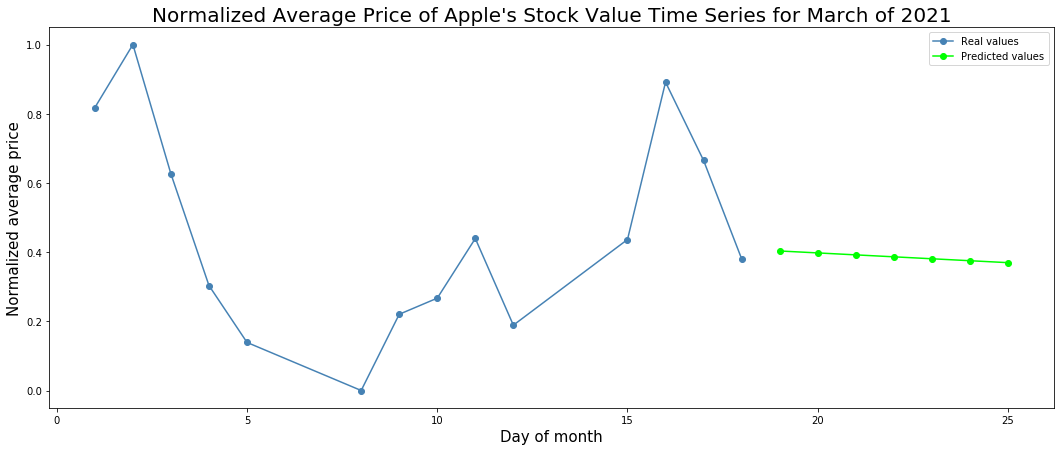

In [235]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,7))
plt.plot(dfp.index, dfp.y, marker='o', color='steelblue', label="Real values")
plt.plot(predp.index, predp.yhat, marker='o', color='lime', label="Predicted values")

plt.legend(loc='best')

plt.title("Normalized Average Price of Apple's Stock Value Time Series for March of 2021", fontdict = {'fontsize': '20',
 'fontweight' : '300',
 'verticalalignment': 'baseline'})
plt.ylabel('Normalized average price', fontdict = {'fontsize': '15'})
plt.xlabel('Day of month', fontdict = {'fontsize': '15'})



plt.show()



# SoaMFlow

Putting all together with SoaMFlow.

### WORK IN PROGRESS...

In [112]:
from soam.core import SoamFlow
from prefect import task

In [113]:
@task
def load_df(df):
    df.to_csv("hola.csv")

In [114]:
with SoamFlow(name="test") as test:
    df = extractor(build_query_kwargs)
    df = ts(data)
    load_df(df)

In [115]:
test.run()

[2021-03-30 09:36:02-0300] INFO - prefect.FlowRunner | Beginning Flow run for 'test'
INFO:prefect.FlowRunner:Beginning Flow run for 'test'
[2021-03-30 09:36:02-0300] INFO - prefect.TaskRunner | Task 'TimeSeriesExtractor': Starting task run...
INFO:prefect.TaskRunner:Task 'TimeSeriesExtractor': Starting task run...
[2021-03-30 09:36:05-0300] INFO - prefect.TaskRunner | Task 'TimeSeriesExtractor': Finished task run for task with final state: 'Success'
INFO:prefect.TaskRunner:Task 'TimeSeriesExtractor': Finished task run for task with final state: 'Success'
[2021-03-30 09:36:05-0300] INFO - prefect.TaskRunner | Task 'Transformer': Starting task run...
INFO:prefect.TaskRunner:Task 'Transformer': Starting task run...
[2021-03-30 09:36:05-0300] INFO - prefect.TaskRunner | Task 'Transformer': Finished task run for task with final state: 'Success'
INFO:prefect.TaskRunner:Task 'Transformer': Finished task run for task with final state: 'Success'
[2021-03-30 09:36:05-0300] INFO - prefect.TaskRun

<Failed: "Some reference tasks failed.">